In [163]:
from bs4 import BeautifulSoup
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import LineString

In [149]:
df_traffic = pd.read_csv('vt_2017_avg_daily_traffic_190919.csv', index_col=0)

In [161]:
df_traffic.head()

,OBJECTID,AADT,BeginMM,BeginRefName,BeginStation,CTCode,EndMM,EndRefName,EndRefNum,EndStation,...,TownName,Year,IsDivided,lat_lon_list,line,mid_point,ATRStation,ATRStatus,BeginRefNum,RouteNum
0,1,10300,0.000,US 5,0,1408.0,0.050,BESWICK DR,TH 179,264,...,HARTFORD,2017,N,"[(43.64699525233922, -72.33550173848928), (43....",NaN,NaN,NaN,NaN,NaN,NaN
1,2,7400,0.559,BRIDGE ST,2952,807.0,1.590,VT 15,NaN,8394,...,MORRISTOWN,2017,N,"[(44.56404670575693, -72.60408540104886), (44....",NaN,NaN,L203,W,MC0238,100.0
2,3,1100,0.000,CLARENDON TL,0,1120.0,0.320,US 7,US 7,1690,...,RUTLAND TOWN,2017,N,"[(43.57314824739289, -72.96940990756653), (43....",NaN,NaN,NaN,H,NaN,NaN
3,4,3700,1.370,BAPTIST ST,7234,1202.0,1.630,GRANITEVILLE RD/MIDDLE RD,FAU 6109,8606,...,BARRE TOWN,2017,N,"[(44.15173777688162, -72.49224493915193), (44....",NaN,NaN,W168,NaN,minor0690,NaN
4,5,11900,0.000,S WILLARD ST (US 7),0,403.0,0.161,S UNION ST,NaN,850,...,BURLINGTON,2017,N,"[(44.46324434045147, -73.2077476074782), (44.4...",NaN,NaN,NaN,NaN,NaN,7.0


In [59]:
df_collisions = pd.read_csv('vt_deer_collisions_2010_2019_190919.csv')

In [62]:
lat_list, lon_list = list(), list()
new_coords = list()
for coord in df_collisions.Coordinates[:]:
    if type(coord)==float:
        new_coords.append(coord)
        lat_list.append(np.nan)
        lon_list.append(np.nan)
    else:
        lat, lon = [float(i) for i in coord.split(',')]
        new_coords.append((lat, lon))
        lat_list.append(lat)
        lon_list.append(lon)

In [63]:
#df_collisions.Coordinates = new_coords
df_collisions['lat'] = lat_list
df_collisions['lon'] = lon_list

In [46]:
coords = df_collisions.dropna(axis='rows', subset=['Coordinates']).Coordinates

In [81]:
df_traffic.loc[0, :]

OBJECTID                                                             1
AADT                                                             10300
BeginMM                                                              0
BeginRefName                                                      US 5
BeginStation                                                         0
CTCode                                                            1408
EndMM                                                             0.05
EndRefName                                                  BESWICK DR
EndRefNum                                                       TH 179
EndStation                                                         264
ETE_ID                                                           S0325
ETE_BeginMM                                                          0
ETE_EndMM                                                         0.05
FunctionalClass                                                      5
RouteN

In [102]:
def process_coord_string(line_segment):
    """
    Take a coord string originally saved as a shapely line and spit out long/lat floats
    """
    path_points = list()
    #for i in df_traffic.loc[0, 'line'][12:-1].split(','):
    for i in line_segment[12:-1].split(','):
        lat, lon = [float(coord) for coord in i.strip().split(' ')]
        path_points.append(tuple([lat, lon]))
    return path_points

In [150]:
df_traffic['lat_lon_list'] = [process_coord_string(line_segment) for line_segment in df_traffic.line]

In [134]:
def process_lines(df):
    """Process placemark data from a KML file"""
    for index, row in df.iterrows():
        try:
            row['line'] = LineString(row['lat_lon_list'])
            row['mid_point'] = row['line'].interpolate(0.5, normalized = True)
        except:
            row['line'] = np.nan
            row['mid_point'] = np.nan

In [156]:
index

0

In [157]:
for index, row in df_traffic.iterrows():
    try:
        #LineString(df_traffic.lat_lon_list[0])
        #print(row.lat_lon_list)
        df_traffic.loc[index, 'line'] = LineString(row.lat_lon_list)
        df_traffic.loc[index, 'mid_point'] = row.line.interpolate(0.5, normalized = True)
    except:
        df_traffic.loc[index, 'line'] = np.nan
        df_traffic.loc[index, 'mid_point'] = np.nan

In [135]:
process_lines(df_traffic)

In [92]:
[i.strip().split(' ') for i in df_traffic.loc[0, 'line'][12:-1].split(',')]

[['43.64699525233922', '-72.33550173848928'],
 ['43.64694585461181', '-72.33538821071163'],
 ['43.6468813667466', '-72.3352339446959'],
 ['43.64680772568318', '-72.33507899381742'],
 ['43.64664504810627', '-72.33476420095099']]

In [89]:
df_traffic.loc[0, 'line'][12:-1].split(',').strip()

AttributeError: 'list' object has no attribute 'strip'

In [159]:
test = df_traffic.dropna(axis='rows', subset=['line', 'mid_point'])

In [154]:
df_traffic.line[0]

'LINESTRING (43.64699525233922 -72.33550173848928, 43.64694585461181 -72.33538821071163, 43.6468813667466 -72.3352339446959, 43.64680772568318 -72.33507899381742, 43.64664504810627 -72.33476420095099)'

In [138]:
df_traffic.line[2]

nan

In [127]:
df_traffic.lat_lon_list[0]

[(43.64699525233922, -72.33550173848928),
 (43.64694585461181, -72.33538821071163),
 (43.6468813667466, -72.3352339446959),
 (43.64680772568318, -72.33507899381742),
 (43.64664504810627, -72.33476420095099)]

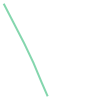

In [133]:
LineString(df_traffic.lat_lon_list[0])

<Figure size 432x720 with 0 Axes>

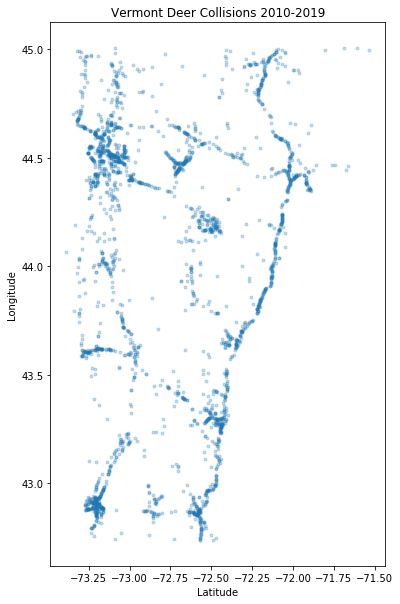

In [162]:
test = df_traffic#.dropna(axis='rows', subset=['lat_lon_list', 'line', 'mid_point'])

colors = plt.get_cmap('copper', lut=test.AADT.max())
plt.figure(figsize=(6,10))

"""for index, row in test.iterrows():    
    y, x = test.loc[index, 'line'].xy
    plt.plot(x, y, color=colors(int(test.loc[index, 'AADT'])))"""

plt.figure(figsize=(6,10))
plt.scatter(df_collisions.lon, df_collisions.lat, marker='.', alpha=.25)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Vermont Deer Collisions 2010-2019')
None

# Loading traffic data
Could make a script with this garbage

In [167]:
def process_coord_string(coord_string):
    """
    Take a coord string and spit out long/lat floats
    """
    space_splits = coord_string.split(' ')
    path_points = list()
    for split in space_splits:
        comma_split = split.split(',')
        lat = float(comma_split[1]) # lat
        lon = float(comma_split[0]) # long
        path_points.append(tuple([lat, lon]))
    return path_points

def process_place(placemark):
    """Process placemark data from a KML file"""
    place_dict = dict()
    for i in placemark.find_all('SimpleData'):
        place_dict[i['name']] = i.text
        
    try:
        place_dict['lat_lon_list'] = process_coord_string(placemark.find('coordinates').string)
        place_dict['line'] = LineString(place_dict['lat_lon_list'])
        place_dict['mid_point'] = place_dict['line'].interpolate(0.5, normalized = True)
    except:
        place_dict['lat_lon_list'] = np.nan
        place_dict['line'] = np.nan
        place_dict['mid_point'] = np.nan

    return place_dict

In [ ]:
with  open('VT_Annual_Average_Daily_Traffic_AADT__2017.kml', encoding='utf8') as f:
    s = BeautifulSoup(f, 'xml')
placemarks = s.find_all('Placemark')
place_list = [process_place(i) for i in placemarks]
df_traffic = pd.DataFrame(place_list)

# Plotting traffic & collisions

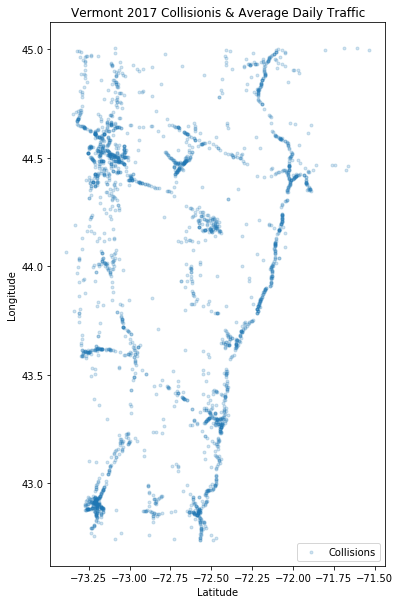

In [410]:
test = df_traffic.dropna(axis='rows', subset=['lat_lon_list', 'line', 'mid_point'])
colors = plt.get_cmap('copper', lut=test.AADT.max())
plt.figure(figsize=(6,10))

"""for index, row in test.iterrows():    
    y, x = test.loc[index, 'line'].xy
    plt.plot(x, y, color=colors(int(test.loc[index, 'AADT'])), zorder=0)"""
    
plt.scatter(df_collisions.lon, df_collisions.lat, 
            marker='.', alpha=.2, c='C0', zorder=1,
            label='Collisions')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Vermont 2017 Collisionis & Average Daily Traffic')
plt.legend(loc='lower right')
#plt.colorbar()
#plt.savefig('vt_deer_collisions_190919.svg')
None

# Matching Collisions to road segments

In [262]:
>>> import numpy as np
>>> from sklearn.cluster import KMeans
>>> from sklearn.metrics import pairwise_distances_argmin_min
>>> X = np.random.randn(10, 2)
>>> km = KMeans(n_clusters=2).fit(X)
>>> closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, np.array([[0, 1]]))
>>> closest

array([0, 0])

In [263]:
km.cluster_centers_

array([[ 0.08809927, -0.26546935],
       [-2.54297533, -0.2208643 ]])

In [204]:
X

array([[-0.96168471,  0.20458671],
       [-0.36557837,  1.11736431],
       [ 1.62720508,  0.10028597],
       [ 0.39699658,  0.40864968],
       [ 0.3103402 , -0.72753534],
       [ 1.23887637,  2.12812773],
       [ 0.08125733,  0.17784032],
       [-0.57211816, -1.82125405],
       [-1.03033104,  1.41298448],
       [-1.6713297 , -2.22453473]])

In [259]:
df_collisions.columns

Index(['Unnamed: 0', 'ObjectID', 'Mapped', 'Crash Date', 'City/Town',
       'Address', 'AOT Route', 'Crash Type', 'Collision Direction', 'Weather',
       'Road Group', 'Report Number', 'Reporting Agency', 'Road Group ID',
       'AOT Actual Milepoint', 'Animal', 'Time of Day', 'Intersection With',
       'Impairment', 'Involving', 'Non Reportable Address',
       'Reporting Agency ID', 'Road Characteristics', 'Road Condition',
       'Street Address', 'Surface Condition', 'AOT Route ID', 'Coordinates',
       'time', 'dayofweek', 'lat', 'lon'],
      dtype='object')

In [264]:
In [1]: from scipy import spatial

In [2]: import numpy as np

In [3]: A = np.random.random((10,2))*100

In [265]:
A

array([[ 8.7101823 , 99.02693991],
       [47.32314862, 65.94470563],
       [85.59343112, 57.38463891],
       [83.22173758, 76.42776477],
       [12.33075364, 88.68636418],
       [ 1.02286507, 34.12293203],
       [75.47931467, 54.00892752],
       [ 7.05667586, 57.25816682],
       [94.77557122, 42.24861451],
       [62.49236445, 65.16404317]])

In [313]:

pt = [60, 60]  # <-- the point to find

spatial.KDTree(A).query(pt)[1] # <-- the nearest point

9

In [314]:
A[9]

array([62.49236445, 65.16404317])

In [270]:
df_traffic.columns

Index(['OBJECTID', 'AADT', 'BeginMM', 'BeginRefName', 'BeginStation', 'CTCode',
       'EndMM', 'EndRefName', 'EndRefNum', 'EndStation', 'ETE_ID',
       'ETE_BeginMM', 'ETE_EndMM', 'FunctionalClass', 'RouteName', 'RouteType',
       'SectionNum', 'StandardRouteCode', 'Status', 'TownName', 'Year',
       'IsDivided', 'lat_lon_list', 'line', 'mid_point', 'ATRStation',
       'ATRStatus', 'BeginRefNum', 'RouteNum'],
      dtype='object')

In [334]:
mid_points = np.zeros((df_traffic.mid_point.shape[0], 2))
for n, mpoint in enumerate(df_traffic.mid_point):
    if type(mpoint)==float:
        pass
    else:
        mid_points[n] = list(mpoint.coords)[0]

mid_point_tree = spatial.KDTree(mid_points)

In [332]:
df_traffic.mid_point.iloc[-1].xy

(array('d', [44.99565537119512]), array('d', [-72.40216790260554]))

In [325]:
mid_points[-5:]

array([[ 44.27961825, -72.43603564],
       [ 45.00998168, -71.55808106],
       [ 43.08347642, -73.18605357],
       [ 43.45912319, -73.1104411 ],
       [ 44.99565537, -72.4021679 ]])

In [286]:
df_collisions.iloc[0].lat

43.297753600990134

In [336]:
aadt_index_nums = list()
for index, row in df_collisions.iterrows():
    #print(row.lat, row.lon)
    num = mid_point_tree.query([row.lat, row.lon])[1]
    aadt_index_nums.append(num)
    print(num, end=', ')

2616, 3093, 2240, 457, 2862, 2697, 2846, 3409, 3461, 2324, 2932, 666, 2391, 909, 478, 603, 2177, 2627, 2880, 3040, 2724, 3132, 1640, 129, 651, 2301, 2193, 585, 2591, 2400, 2748, 585, 1697, 1571, 1307, 1354, 651, 3363, 487, 1347, 680, 2846, 3255, 99, 2413, 3095, 2637, 1691, 2260, 2846, 1707, 3085, 1699, 1216, 2559, 1439, 1770, 1932, 2578, 607, 2668, 755, 756, 1299, 2880, 2134, 1786, 1313, 3373, 3168, 2042, 1690, 2065, 755, 1770, 661, 1995, 2662, 2822, 619, 1606, 2012, 1425, 2799, 625, 603, 2765, 3229, 2793, 2639, 511, 2436, 603, 1702, 1500, 675, 1843, 1565, 1281, 2372, 2176, 2875, 696, 3266, 3223, 1850, 2105, 625, 2105, 1782, 2377, 2617, 2591, 1671, 2643, 115, 916, 930, 1955, 2559, 993, 245, 2771, 3223, 1397, 834, 2815, 2849, 1862, 3269, 2734, 603, 2383, 3420, 1449, 1516, 3249, 2109, 2006, 2831, 1466, 1697, 1450, 666, 2862, 3208, 2911, 647, 2328, 2854, 1766, 1309, 2084, 1640, 619, 2505, 1539, 3371, 2097, 2295, 1377, 2027, 2677, 2624, 2846, 2344, 1558, 3326, 2033, 1154, 1736, 2721, 3363,

In [321]:
df_traffic.shape

(3543, 29)

In [322]:
df_collisions.shape

(2590, 33)

In [300]:
df_collisions["traffic_index"] = aadt_index_nums

In [304]:
traffic_collision_series = df_collisions.groupby('traffic_index').count().ObjectID

In [323]:
traffic_collision_series.index

Int64Index([   3,    6,   10,   18,   25,   50,   52,   53,   63,   74,
            ...
            3517, 3518, 3521, 3523, 3524, 3525, 3526, 3531, 3532, 3543],
           dtype='int64', name='traffic_index', length=1100)

In [307]:
df_traffic.shape

(3543, 29)

In [357]:
collision_per_traffic = df_traffic.copy().iloc[traffic_collision_series.index[:-1],:]
collision_per_traffic.loc[:,'AADT'] = collision_per_traffic.AADT.astype(int).values

In [358]:
collision_per_traffic.shape

(1099, 29)

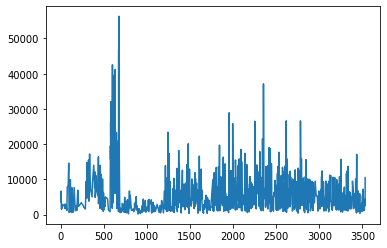

In [359]:
plt.plot(collision_per_traffic.AADT)

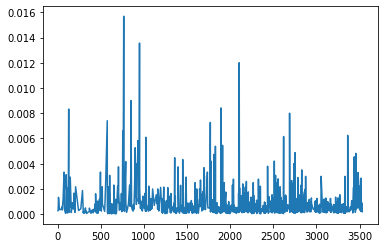

In [360]:
plt.plot(traffic_collision_series.iloc[:-1] / collision_per_traffic.AADT)

In [361]:
collision_per_traffic['normal_aadt'] = traffic_collision_series.iloc[:-1] / collision_per_traffic.AADT

In [364]:
collision_per_traffic.normal_aadt /= collision_per_traffic.normal_aadt.max()

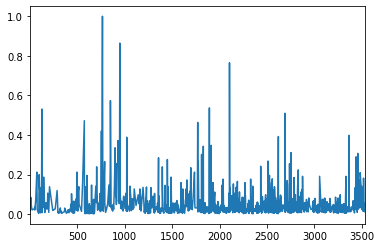

In [367]:
collision_per_traffic.normal_aadt.plot()

- Okay so make a new traffic dataframe with only the indices in `df_collisions.traffic_index`. 
- Then I can normalize the `df_traffic_new.AADT` number by the count of collisions in the index that I make with `groupby`

In [372]:
test.index

Int64Index([   3,    6,   10,   18,   25,   50,   52,   53,   63,   74,
            ...
            3516, 3517, 3518, 3521, 3523, 3524, 3525, 3526, 3531, 3532],
           dtype='int64', length=1099)

In [375]:
colors(test.loc[3, 'normal_aadt'])

(1.0, 0.7812, 0.4975, 1.0)

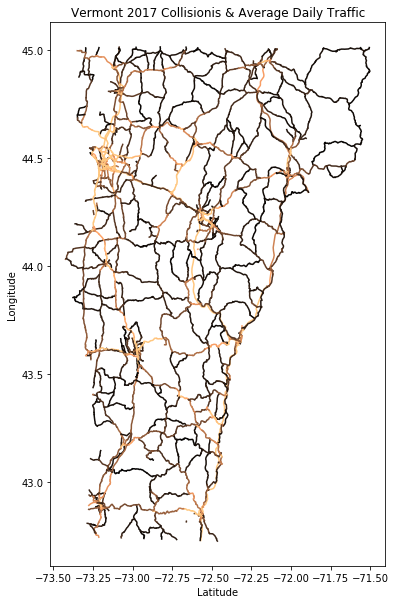

In [380]:
test = df_traffic.dropna(axis='rows', subset=['lat_lon_list', 'line', 'mid_point'])
colors = plt.get_cmap('copper', lut=test.AADT.max())
plt.figure(figsize=(6,10))

for index, row in test.iterrows():    
    y, x = test.loc[index, 'line'].xy
    plt.plot(x, y, color=colors(int(test.loc[index, 'AADT'])), zorder=0)
    

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Vermont 2017 Collisionis & Average Daily Traffic')
#plt.colorbar(colors)
#plt.savefig('vt_deer_collisions_2017_avg_daily_traffic.svg')
None

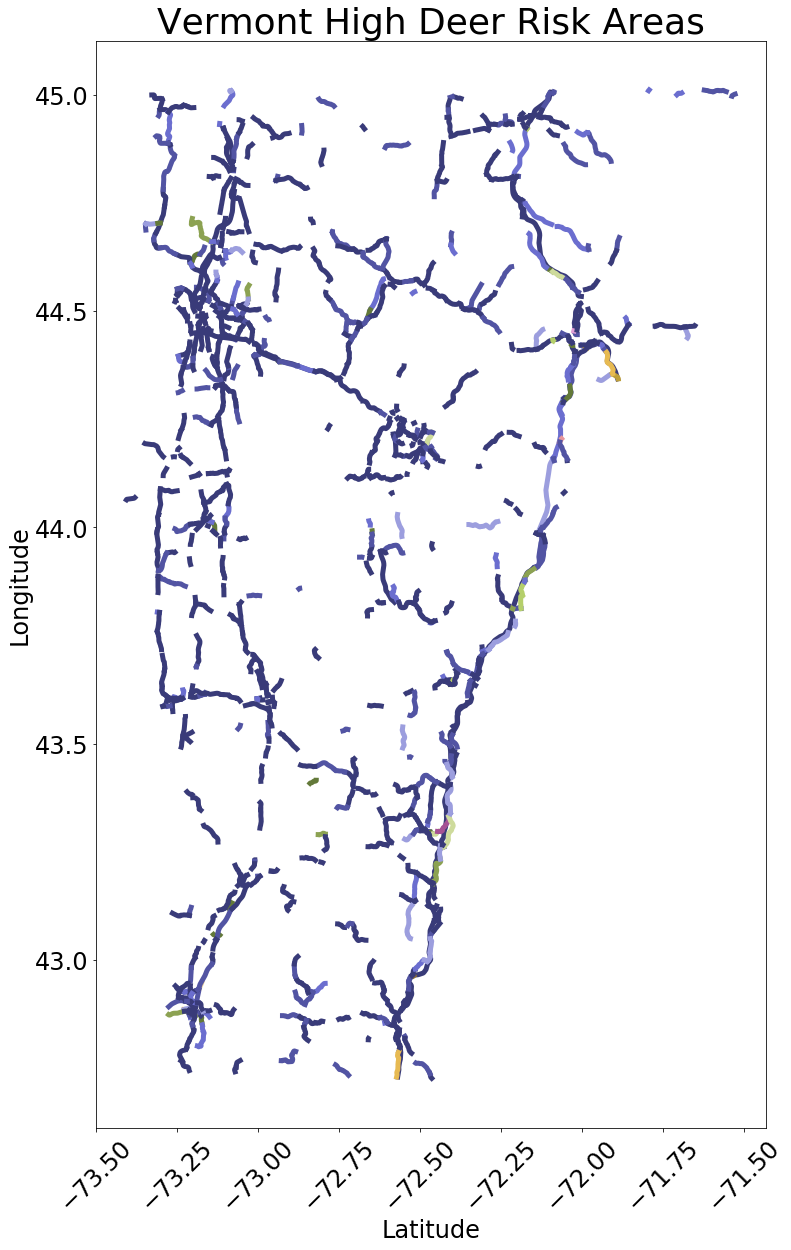

In [406]:
test = collision_per_traffic.dropna(axis='rows', subset=['lat_lon_list', 'line', 'mid_point'])
colors = plt.get_cmap('tab20b') #, lut=test.normal_aadt.max())
plt.figure(figsize=(3*4,5*4))

for index, row in test.iloc[:,:].iterrows():    
    y, x = row.line.xy
    plt.plot(x, y, 
             color=colors(row.normal_aadt),
             lw=5, alpha=1)
    #print(colors(row.normal_aadt), row.normal_aadt)
    
'''plt.scatter(df_collisions.lon, df_collisions.lat, 
            marker='.', alpha=.1, c='C0', zorder=1,
            label='Collisions')'''

plt.xlabel('Latitude', fontsize=24)
plt.ylabel('Longitude', fontsize=24)
plt.title('Vermont High Deer Risk Areas', fontsize=36)
plt.xticks(fontsize=24, rotation=45)
plt.yticks(fontsize=24)
#plt.legend(loc='lower right')
#plt.colorbar()
#plt.savefig('vt_deer_collisions_per_avg_daily_traffic_190919.svg')
None